In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from k_means import run_kmeans

## Preferencia de usuarios con bajo consumo de sms por el servicio de voz

In [79]:
df = pd.read_csv("../data/muestra.csv")

df['START_DATE'] = pd.to_datetime(df['START_DATE'])
df['END_DATE'] = pd.to_datetime(df['END_DATE'])
df['DURATION_HOURS'] = (df['END_DATE'] - df['START_DATE']).dt.total_seconds() / 3600

print("PASO 1: Analizando SMS (SERVICE_CATEGORY=2)")
df_sms = df[df['SERVICE_CATEGORY'] == 2].copy()
usuarios_sms = df_sms.groupby('OWNER_CUST_ID').agg(
    total_usage=('ACTUAL_USAGE', 'sum')
).reset_index()
print(f"Registros de SMS: {len(df_sms)}")

usuarios_sms.columns = ['OWNER_CUST_ID', 'uso_sms']
print(f"Usuarios únicos en SMS: {len(usuarios_sms)}")
print()

print("PASO 2: Analizando VOZ (SERVICE_CATEGORY=1)")
df_voz = df[df['SERVICE_CATEGORY'] == 1].copy()
usuarios_voz = df_voz.groupby('OWNER_CUST_ID').agg(
    total_usage=('ACTUAL_USAGE', 'sum')
).reset_index()
print(f"Registros de VOZ: {len(df_voz)}")

usuarios_voz.columns = ['OWNER_CUST_ID', 'uso_voz']
print(f"Usuarios únicos en VOZ: {len(usuarios_voz)}")
print()

PASO 1: Analizando SMS (SERVICE_CATEGORY=2)
Registros de SMS: 1551
Usuarios únicos en SMS: 324

PASO 2: Analizando VOZ (SERVICE_CATEGORY=1)
Registros de VOZ: 156
Usuarios únicos en VOZ: 89



## Proceso de Clustering

In [80]:
print("PASO 3: Clustering en SMS (K-means)")

usuarios_sms_cluster = usuarios_sms.copy()
usuarios_sms_cluster = usuarios_sms_cluster.rename(columns={'uso_sms': 'total_usage'})

result_sms = run_kmeans(usuarios_sms_cluster, features=['total_usage'])

cluster_medias_sms = result_sms.groupby('cluster_kmeans')['total_usage'].mean().sort_values()
orden_sms = cluster_medias_sms.index.tolist()
mapeo_sms = {orden_sms[0]: 'Bajo', orden_sms[1]: 'Normal', orden_sms[2]: 'Alto'}
result_sms['perfil_sms'] = result_sms['cluster_kmeans'].map(mapeo_sms)

result_sms_reset = result_sms.reset_index()
usuarios_sms = result_sms_reset[['OWNER_CUST_ID', 'total_usage', 'cluster_kmeans', 'perfil_sms']].copy()
usuarios_sms.columns = ['OWNER_CUST_ID', 'uso_sms', 'cluster_sms', 'perfil_sms']

print("\nPerfiles en DATOS:")
print(usuarios_sms.groupby('perfil_sms')['uso_sms'].describe())
print()

usuarios_voz_cluster = usuarios_voz[['OWNER_CUST_ID', 'uso_voz']].copy()
usuarios_voz_cluster = usuarios_voz_cluster.rename(columns={'uso_voz': 'total_usage'})

# Aplicar run_kmeans
result_voz = run_kmeans(usuarios_voz_cluster, features=['total_usage'])

# Mapear clusters a perfiles (Bajo, Normal, Alto)
cluster_medias_voz = result_voz.groupby('cluster_kmeans')['total_usage'].mean().sort_values()
orden_voz = cluster_medias_voz.index.tolist()
mapeo_voz = {orden_voz[0]: 'Bajo', orden_voz[1]: 'Normal', orden_voz[2]: 'Alto'}
result_voz['perfil_voz'] = result_voz['cluster_kmeans'].map(mapeo_voz)

# Volver a unir con OWNER_CUST_ID
result_voz_reset = result_voz.reset_index()
usuarios_voz = result_voz_reset[['OWNER_CUST_ID', 'total_usage', 'cluster_kmeans', 'perfil_voz']].copy()
usuarios_voz.columns = ['OWNER_CUST_ID', 'uso_voz', 'cluster_voz', 'perfil_voz']

print("\nPerfiles en voz:")
print(usuarios_voz.groupby('perfil_voz')['uso_voz'].describe())
print()

PASO 3: Clustering en SMS (K-means)

Perfiles en DATOS:
            count        mean       std    min     25%    50%     75%    max
perfil_sms                                                                  
Alto          1.0  123.000000       NaN  123.0  123.00  123.0  123.00  123.0
Bajo        297.0    2.821549  2.387709    1.0    1.00    2.0    4.00   12.0
Normal       26.0   22.692308  9.302770   13.0   16.25   19.0   30.25   47.0


Perfiles en voz:
            count         mean         std     min     25%     50%     75%  \
perfil_voz                                                                   
Alto          1.0  1327.000000         NaN  1327.0  1327.0  1327.0  1327.0   
Bajo         77.0    47.194805   42.362483     0.0    14.0    35.0    60.0   
Normal       11.0   316.000000  126.790378   182.0   231.5   277.0   337.0   

               max  
perfil_voz          
Alto        1327.0  
Bajo         157.0  
Normal       602.0  



In [81]:
# 8) TEST DE HIPÓTESIS: ¿Bajos consumidores de datos prefieren SMS?
# Hipótesis: H0: p <= 0.60 (60% o menos de bajos consumidores de datos son altos/normales en SMS)
# Hipótesis alternativa H1: p > 0.60

print("="*70)
print("TEST DE HIPÓTESIS: PREFERENCIA DE VOZ POR BAJOS CONSUMIDORES DE SMS")
print("="*70)
print()

# Cruzar información: usuarios bajos en datos vs su clasificación en SMS
cruce = usuarios_sms.merge(usuarios_voz, on='OWNER_CUST_ID', how='inner')

# Identificar bajos consumidores de sms
bajos_sms = cruce[cruce['perfil_sms'] == 'Bajo'].copy()

print(f"Total de bajos consumidores de sms: {len(bajos_sms)}")
print(f"Distribución en bajos consumidores de sms:")
print(bajos_sms['perfil_voz'].value_counts())
print()

# De los bajos en datos, contar cuántos son ALTOS o NORMALES en SMS
bajos_sms['es_alto_o_normal_voz'] = bajos_sms['perfil_voz'].isin(['Alto', 'Normal'])
count_altos_normales = bajos_sms['es_alto_o_normal_voz'].sum()
proporcion_observada = count_altos_normales / len(bajos_sms) if len(bajos_sms) > 0 else 0

print(f"Bajos en SMS que son ALTOS o NORMALES en VOZ: {count_altos_normales} de {len(bajos_sms)}")
print(f"Proporción observada: {proporcion_observada:.4f} ({proporcion_observada*100:.2f}%)")
print()

# TEST DE PROPORCIÓN CON 95% DE CONFIANZA
# Usando test binomial
from scipy.stats import binomtest
p0 = 0.60  # proporción bajo la hipótesis nula
n = len(bajos_sms)
x = count_altos_normales

# Test unilateral (cola derecha): ¿es la proporción significativamente mayor a 60%?
result_binom = binomtest(x, n, p0, alternative='greater')
pvalue = result_binom.pvalue

print("TEST BINOMIAL (Hipótesis unilateral cola derecha):")
print(f"H0: p ≤ 0.60 (bajos consumidores de SMS NO prefieren principalmente VOZ)")
print(f"H1: p > 0.60 (bajos consumidores de SMS SÍ prefieren principalmente VOZ)")
print(f"Nivel de significancia: α = 0.05 (confianza 95%)")
print(f"p-value: {pvalue:.6f}")
print()

if pvalue < 0.05:
    print("✅ RESULTADO: RECHAZAMOS H0")
    print("   Conclusión: Con 95% de confianza, la mayoría de bajos consumidores de SMS")
    print("   SÍ prefieren VOZ (más del 60% son altos/normales en SMS)")
else:
    print("❌ RESULTADO: NO RECHAZAMOS H0")
    print("   Conclusión: Con 95% de confianza, NO podemos afirmar que la mayoría de")
    print("   bajos consumidores de SMS prefieren VOZ")

print()
print("="*70)

# INTERVALO DE CONFIANZA AL 95%
# Intervalo de confianza de Wilson
def wilson_ci(x, n, confidence=0.95):
    alpha = 1 - confidence
    z = stats.norm.ppf(1 - alpha/2)
    p_hat = x / n
    denominator = 1 + z**2/n
    centre_adjusted = (p_hat + z**2/(2*n)) / denominator
    adjusted_deviation = z * np.sqrt(p_hat*(1-p_hat)/n + z**2/(4*n**2)) / denominator
    return (centre_adjusted - adjusted_deviation, centre_adjusted + adjusted_deviation)

ic_lower, ic_upper = wilson_ci(x, n, 0.95)

print("INTERVALO DE CONFIANZA AL 95% (Método de Wilson):")
print(f"IC: [{ic_lower:.4f}, {ic_upper:.4f}]")
print(f"IC: [{ic_lower*100:.2f}%, {ic_upper*100:.2f}%]")
print()

if ic_lower > 0.60:
    print("✅ El intervalo está completamente por encima de 60%")
    print("   Confirmamos: Más del 60% de bajos consumidores de datos prefieren SMS")
elif ic_upper < 0.60:
    print("❌ El intervalo está completamente por debajo de 60%")
    print("   No se cumple la hipótesis")
else:
    print("⚠️  El intervalo contiene 60%")
    print("   El resultado es borderline/inconcluso")


TEST DE HIPÓTESIS: PREFERENCIA DE VOZ POR BAJOS CONSUMIDORES DE SMS

Total de bajos consumidores de sms: 23
Distribución en bajos consumidores de sms:
perfil_voz
Bajo      19
Normal     4
Name: count, dtype: int64

Bajos en SMS que son ALTOS o NORMALES en VOZ: 4 de 23
Proporción observada: 0.1739 (17.39%)

TEST BINOMIAL (Hipótesis unilateral cola derecha):
H0: p ≤ 0.60 (bajos consumidores de SMS NO prefieren principalmente VOZ)
H1: p > 0.60 (bajos consumidores de SMS SÍ prefieren principalmente VOZ)
Nivel de significancia: α = 0.05 (confianza 95%)
p-value: 0.999995

❌ RESULTADO: NO RECHAZAMOS H0
   Conclusión: Con 95% de confianza, NO podemos afirmar que la mayoría de
   bajos consumidores de SMS prefieren VOZ

INTERVALO DE CONFIANZA AL 95% (Método de Wilson):
IC: [0.0698, 0.3714]
IC: [6.98%, 37.14%]

❌ El intervalo está completamente por debajo de 60%
   No se cumple la hipótesis


## Experimentos basados en el uso compartido de los servicios para realizar análisis que resultan

In [82]:
df = df[df['SERVICE_CATEGORY'].isin([1,2,5])]
print("="*70)
print("Nuevos analisis relacionados con el uso compartido de servicios")
print("="*70)

# Filtrar por cada servicio
voz = df[df['SERVICE_CATEGORY'] == 1]
sms = df[df['SERVICE_CATEGORY'] == 2]
datos = df[df['SERVICE_CATEGORY'] == 5]

#Ahora agrupamos por usuario
voz_usuarios = voz.groupby('OBJ_ID')['ACTUAL_USAGE'].sum().rename('uso_voz')
sms_usuarios = sms.groupby('OBJ_ID')['ACTUAL_USAGE'].sum().rename('uso_sms')
datos_usuarios = datos.groupby('OBJ_ID')['ACTUAL_USAGE'].sum().rename('uso_datos')

usuarios = pd.concat([voz_usuarios, sms_usuarios, datos_usuarios], axis=1).fillna(0).reset_index()

usuarios['uso_total'] = (usuarios['uso_voz'] + usuarios['uso_sms'] + usuarios['uso_datos'])

usuarios = usuarios[usuarios['uso_total'] > 0]

print(usuarios['uso_total'][:10])

Nuevos analisis relacionados con el uso compartido de servicios
0         152.0
1         487.0
2    16312108.0
3     3518020.0
4     9236223.0
5          13.0
6         197.0
7          48.0
8     1316092.0
9    92848001.0
Name: uso_total, dtype: float64


In [83]:
print("=" * 70) 
print("Calculemos las proporciones")
print("=" * 70)
usuarios['prop_voz'] = usuarios['uso_voz'] / usuarios['uso_total']
usuarios['prop_sms'] = usuarios['uso_sms'] / usuarios['uso_total']
usuarios['prop_datos'] = usuarios['uso_datos'] / usuarios['uso_total']

print(usuarios['prop_datos'][:10])
print(usuarios['prop_sms'][:10])
print(usuarios['prop_voz'][:10])

Calculemos las proporciones
0    0.000000
1    0.000000
2    0.999994
3    0.999990
4    0.999994
5    0.000000
6    0.000000
7    0.000000
8    0.999987
9    0.999997
Name: prop_datos, dtype: float64
0    0.000000e+00
1    8.213552e-03
2    0.000000e+00
3    0.000000e+00
4    4.330775e-07
5    0.000000e+00
6    0.000000e+00
7    0.000000e+00
8    0.000000e+00
9    5.385146e-08
Name: prop_sms, dtype: float64
0    1.000000
1    0.991786
2    0.000006
3    0.000010
4    0.000006
5    1.000000
6    1.000000
7    1.000000
8    0.000013
9    0.000003
Name: prop_voz, dtype: float64


Aplicando k-means a las proporciones, variando el valor de k


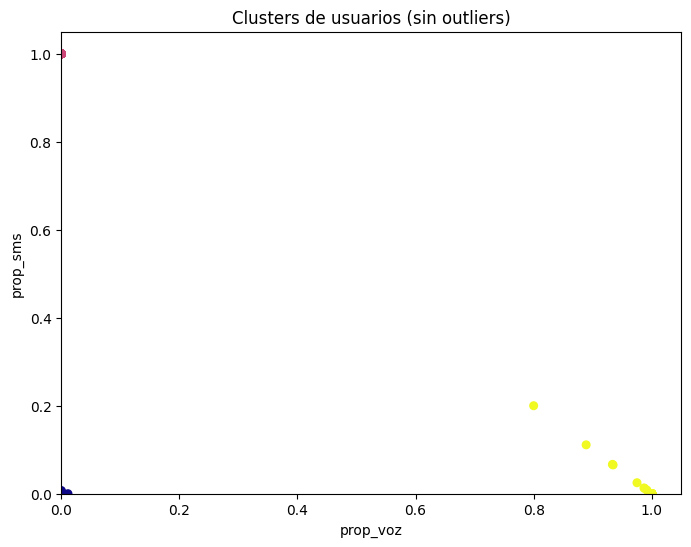

,prop_voz,prop_sms,prop_datos
cluster_kmeans,,,
0,0.000017,0.000020,0.999963
1,0.000000,1.000000,0.000000
2,0.987465,0.012535,0.000000


In [84]:
print("=" * 70) 
print("Aplicando k-means a las proporciones, variando el valor de k")
print("=" * 70)

features = ['prop_voz', 'prop_sms', 'prop_datos']
results = run_kmeans(usuarios, features)

results.groupby("cluster_kmeans")[features].mean()

# Segmentación de usuarios por relación de consumo y franja horaria

En este experimento se analiza si la especialización extrema por servicio
observada a nivel global se mantiene cuando se introduce el contexto temporal.

Se definen tres franjas horarias:
- Hora Pico: 20:00 – 23:00
- Hora Sueño: 23:00 – 05:00
- Despertar Poblacional: 05:00 – 08:00

Para cada franja se agrupan los usuarios y se calcula la proporción relativa
de consumo en Voz, SMS y Datos. Posteriormente se aplica K-Means con K=3.


In [85]:
def filtrar_franja(df, inicio, fin):
    if inicio < fin:
        return df[
            (df["START_DATE"].dt.hour >= inicio) &
            (df["START_DATE"].dt.hour < fin)
        ]
    else:
        # Franja que cruza medianoche
        return df[
            (df["START_DATE"].dt.hour >= inicio) |
            (df["START_DATE"].dt.hour < fin)
        ]

franjas = {
    "Hora Sueño (00-05)": filtrar_franja(df, 23, 5),
    "Despertar (05-08)": filtrar_franja(df, 5, 8),
    "Hora Laboral (08-12)" : filtrar_franja(df, 8, 12)
}

for nombre, subdf in franjas.items():
    print(nombre, "→ registros:", len(subdf))


Hora Sueño (00-05) → registros: 2113
Despertar (05-08) → registros: 3342
Hora Laboral (08-12) → registros: 4127


## Hipótesis del experimento

1. H1: La especialización extrema por servicio se mantiene en todas las franjas.
2. H2: En determinadas franjas aparecen usuarios con consumo mixto.
3. H3: El tipo de usuario predominante varía según la franja horaria.


In [86]:
# Funcion para determinar usuarios por franjas
def construir_usuarios(df_franja):
    voice = df_franja[df_franja["SERVICE_CATEGORY"] == 1]
    sms   = df_franja[df_franja["SERVICE_CATEGORY"] == 2]
    data  = df_franja[df_franja["SERVICE_CATEGORY"] == 5]

    voice_u = voice.groupby("OBJ_ID")["ACTUAL_USAGE"].sum().rename("voice")
    sms_u   = sms.groupby("OBJ_ID")["ACTUAL_USAGE"].sum().rename("sms")
    data_u  = data.groupby("OBJ_ID")["ACTUAL_USAGE"].sum().rename("data")

    usuarios = pd.concat([voice_u, sms_u, data_u], axis=1).fillna(0)
    usuarios["total"] = usuarios.sum(axis=1)
    usuarios = usuarios[usuarios["total"] > 0]

    usuarios["p_voice"] = usuarios["voice"] / usuarios["total"]
    usuarios["p_sms"]   = usuarios["sms"] / usuarios["total"]
    usuarios["p_data"]  = usuarios["data"] / usuarios["total"]

    return usuarios.reset_index()


In [87]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

def kmeans_usuarios(df_usuarios, k=3):
    X = df_usuarios[["p_voice", "p_sms", "p_data"]]
    X_scaled = StandardScaler().fit_transform(X)

    kmeans = KMeans(n_clusters=k, random_state=42)
    df_usuarios["cluster"] = kmeans.fit_predict(X_scaled)

    return df_usuarios


## Resultados por franja horaria

Se muestran:
- Tamaño de cada cluster
- Proporciones promedio de consumo
- Visualización de los clusters



Hora Sueño (00-05)

Distribución de clusters:
cluster
0    0.932110
1    0.049541
2    0.018349
Name: proportion, dtype: float64

Centroides promedio:
          p_voice     p_sms    p_data
cluster                              
0        0.000008  0.000009  0.999983
1        0.000000  1.000000  0.000000
2        0.960490  0.039510  0.000000


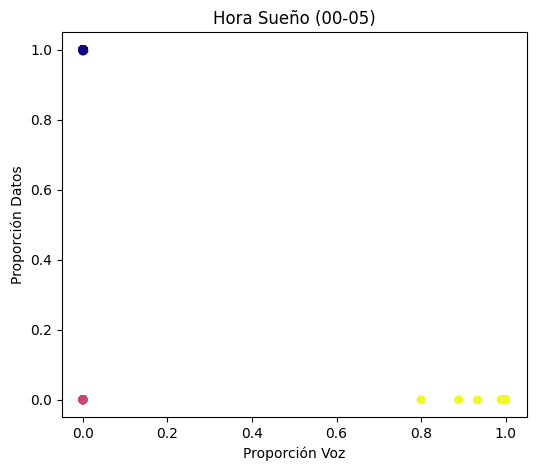


Despertar (05-08)

Distribución de clusters:
cluster
0    0.960843
1    0.028614
2    0.010542
Name: proportion, dtype: float64

Centroides promedio:
              p_voice         p_sms  p_data
cluster                                    
0        2.222409e-07  3.060682e-08     1.0
1        0.000000e+00  1.000000e+00     0.0
2        9.994109e-01  5.891016e-04     0.0


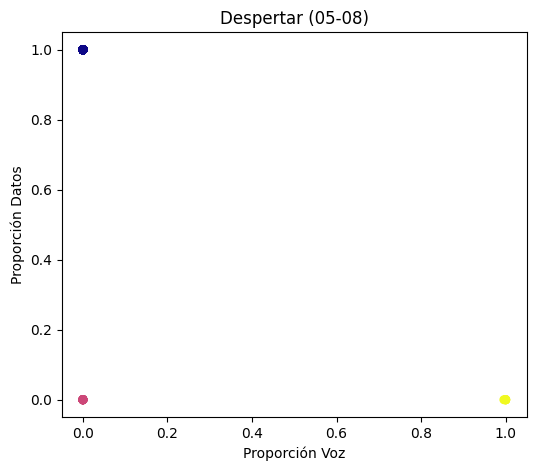


Hora Laboral (08-12)

Distribución de clusters:
cluster
0    0.711699
1    0.239554
2    0.048747
Name: proportion, dtype: float64

Centroides promedio:
          p_voice     p_sms   p_data
cluster                             
0        0.000002  0.000019  0.99998
1        0.000000  1.000000  0.00000
2        0.998278  0.001722  0.00000


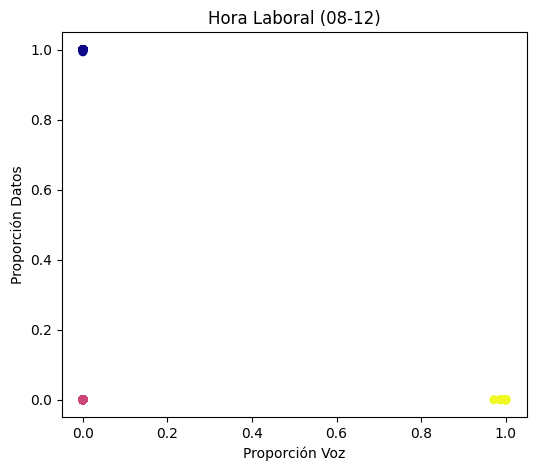

In [88]:
resultados = {}

for nombre, subdf in franjas.items():
    print("\n", "="*50)
    print(nombre)

    usuarios = construir_usuarios(subdf)
    usuarios = kmeans_usuarios(usuarios, k=3)

    resumen = usuarios.groupby("cluster")[["p_voice","p_sms","p_data"]].mean()
    conteo = usuarios["cluster"].value_counts(normalize=True)

    print("\nDistribución de clusters:")
    print(conteo)

    print("\nCentroides promedio:")
    print(resumen)

    resultados[nombre] = usuarios

    # Gráfico
    plt.figure(figsize=(6,5))
    plt.scatter(
        usuarios["p_voice"],
        usuarios["p_data"],
        c=usuarios["cluster"],
        cmap="plasma",
        s=30
    )
    plt.xlabel("Proporción Voz")
    plt.ylabel("Proporción Datos")
    plt.title(nombre)
    plt.show()


## Evaluación de hipótesis

H1 (especialización se mantiene):
- Se valida si los centroides siguen dominados por un solo servicio.

H2 (usuarios mixtos):
- Se valida si aparece un cluster con proporciones balanceadas.

H3 (variación temporal):
- Se valida si cambia el cluster dominante entre franjas.


In [89]:
for nombre, usuarios in resultados.items():
    print("\n", nombre)
    centroides = usuarios.groupby("cluster")[["p_voice","p_sms","p_data"]].mean()
    print(centroides)

    mixtos = centroides[
        (centroides.max(axis=1) < 0.6)
    ]

    if len(mixtos) > 0:
        print("→ Aparecen usuarios mixtos")
    else:
        print("→ Especialización dominante")



 Hora Sueño (00-05)
          p_voice     p_sms    p_data
cluster                              
0        0.000008  0.000009  0.999983
1        0.000000  1.000000  0.000000
2        0.960490  0.039510  0.000000
→ Especialización dominante

 Despertar (05-08)
              p_voice         p_sms  p_data
cluster                                    
0        2.222409e-07  3.060682e-08     1.0
1        0.000000e+00  1.000000e+00     0.0
2        9.994109e-01  5.891016e-04     0.0
→ Especialización dominante

 Hora Laboral (08-12)
          p_voice     p_sms   p_data
cluster                             
0        0.000002  0.000019  0.99998
1        0.000000  1.000000  0.00000
2        0.998278  0.001722  0.00000
→ Especialización dominante


# Conclusiones

En este trabajo se realizó un análisis experimental del **comportamiento de consumo de usuarios de servicios de telecomunicaciones**, considerando **voz, SMS y datos móviles**, con el objetivo de identificar **patrones de uso**, **clasificar usuarios según su relación de consumo** y evaluar **cómo dichos patrones varían en función del tiempo**.

---

## Proceso metodológico seguido

### 1. Preparación y limpieza de datos

El análisis comenzó con la **conversión de las variables temporales** (`START_DATE`, `END_DATE`) a formato datetime y el cálculo de la **duración de cada sesión** en horas.
Posteriormente, se eliminaron **outliers previamente detectados** mediante DBSCAN, con el fin de evitar que comportamientos extremos distorsionaran el proceso de clustering.

Este paso permitió trabajar con un conjunto de datos más representativo del comportamiento típico de los usuarios.

---

### 2. Construcción del perfil de usuario

Para cada usuario (`OBJ_ID`), se agregaron los consumos por servicio y se transformaron en **proporciones relativas**:

* Proporción de consumo en voz
* Proporción de consumo en SMS
* Proporción de consumo en datos

Este enfoque permitió:

* Comparar usuarios independientemente del volumen absoluto de consumo
* Capturar la **relación entre servicios**, que era el objetivo central del análisis

La suma de las proporciones por usuario es igual a 1, garantizando una representación normalizada del comportamiento.

---

### 3. Elección de categorías de usuario

Inicialmente se planteó definir **categorías manuales** (por ejemplo, “usuario mixto”, “usuario balanceado”), estableciendo márgenes porcentuales entre servicios.
Sin embargo, los resultados obtenidos mediante clustering mostraron que:

* Los usuarios se agrupan de forma **natural y extremadamente separada**
* Los centroides están **claramente dominados por un único servicio**
* No existen zonas intermedias significativas entre clusters

Por esta razón, **no tuvo sentido forzar categorías artificiales**, ya que los propios datos revelaron perfiles de consumo bien definidos.
La categorización final se realizó de forma **data-driven**, usando K-Means sobre las proporciones de consumo.

---

### 4. Clustering de usuarios

Se utilizó **K-Means** con tres clusters, justificados por:

* El número de servicios analizados (voz, SMS, datos)
* La clara separación observada entre los grupos
* La interpretabilidad directa de los centroides

Los clusters resultantes representan:

* Usuarios dominados por consumo de datos
* Usuarios dominados por consumo de SMS
* Usuarios dominados por consumo de voz

La alta pureza de los centroides confirmó la robustez del modelo y la claridad de los patrones presentes en los datos.

---

### 5. Análisis temporal por franjas horarias

El dataset se segmentó en distintas franjas horarias:

* Hora Sueño (00–05)
* Despertar (05–08)
* Hora Laboral (08–12)

Para cada franja:

* Se reconstruyeron los perfiles de usuario
* Se aplicó nuevamente el clustering
* Se analizaron centroides y distribuciones relativas

Este enfoque permitió evaluar la **estabilidad temporal de los perfiles de consumo**.

---

## Resultados principales

### Especialización del consumo

En todas las franjas horarias, los usuarios muestran un **alto grado de especialización**, concentrando casi la totalidad de su consumo en un único servicio.
Esto se refleja en centroides con proporciones cercanas al 100% para uno de los servicios y prácticamente nulas para los demás.

---

### Ausencia de usuarios mixtos

Contrario a lo esperado inicialmente, **no se identificaron perfiles de consumo balanceado**.
Los usuarios no combinan de forma significativa voz, SMS y datos dentro de las ventanas temporales analizadas.

Este resultado indica que:

* El comportamiento de consumo es altamente segmentado
* Los servicios no se utilizan de forma simultánea o complementaria en el corto plazo

---

### Influencia de la franja horaria

La franja horaria **no altera la estructura de los perfiles**, pero sí afecta su **prevalencia**:

* El consumo de datos domina en todas las franjas
* La proporción de usuarios de voz y SMS varía según el momento del día

Esto sugiere que el tiempo influye en **cuántos usuarios** pertenecen a cada tipo, pero no en **qué tipos existen**.

---

## Conclusión general

El análisis demuestra que el consumo de servicios de telecomunicaciones presenta **patrones de uso altamente especializados**, estables en el tiempo y claramente separables mediante técnicas de clustering no supervisado.

La experimentación evidenció que:

* La clasificación basada en proporciones es más adecuada que el uso de valores absolutos
* No es necesario definir categorías manuales cuando los datos muestran una separación natural
* El comportamiento de los usuarios es consistente y predecible dentro de las franjas analizadas

Este estudio sienta una base sólida para análisis futuros, como:

* Evolución del usuario entre perfiles a largo plazo
* Detección de cambios de comportamiento ante eventos externos
* Segmentación avanzada para optimización de servicios o gestión de fallos